## Notes

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import scikitplot
import datetime
import seaborn as sns
import datetime
import random
import uuid
sns.set()

import os, sys
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)

## Dataset

In [ ]:
def get_data():
    df = pd.read_csv('../data/fakedata.csv', index_col='id')
    df['id'] = df.index
    df = df.rename(columns={'class':'label'})
    return df

df = get_data()
df.head()

In [ ]:
categorical = ['country', 'device']
identifiers = ['id', 'user', 'name']
numerical = ['amount']
target = 'label'

In [ ]:
# Shuffle and sample 50%
features = df.sample(frac=.5)
df.head()

## Summary Stats

In [ ]:
df.info()
df.describe()
df.nunique()
df.isnull().sum() # null count
df.label.value_counts()
#df.describe(include='O') # Categorical columns

## Time


### Time Features (Hour, Min, Day)

In [ ]:
df['datetime'] = df.time.apply(datetime.datetime.fromtimestamp)
df['time_hour'] = df.datetime.dt.round('H')
df['time_day'] = df.datetime.dt.round('D')
df['hour'] = df.datetime.dt.hour
df['minute'] = df.datetime.dt.minute
df['daywk'] = df.datetime.dt.dayofweek
df.head()

### Date Ranges

In [ ]:
# Create a date range
pd.date_range('2015-07-03', '2015-07-10')

# Create a daterange of n periods with f frequency
pd.date_range('2015-07-03', periods=8, freq='6H')

In [ ]:
# Query Dates
df[df.datetime > np.datetime64('2015-07-11')].head()

### Resample (Moving Average)

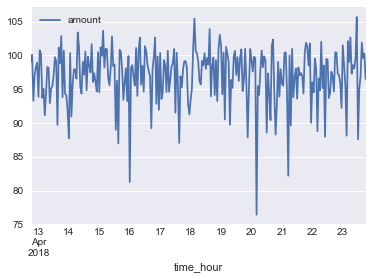

In [79]:
# Plot Hourly Mean
df[['time_hour','amount']].groupby('time_hour').mean().plot()

In [97]:
# Add Rolling Mean (of last 10 observations)
df['ma10'] = df[['id','time_hour','amount']].set_index('time_hour').rolling(10).mean().fillna(0)['amount'].values
df.ma10.head()

id
4908    0.0
6327    0.0
8452    0.0
831     0.0
7944    0.0
Name: ma10, dtype: float64

## Plotting

### Time Series

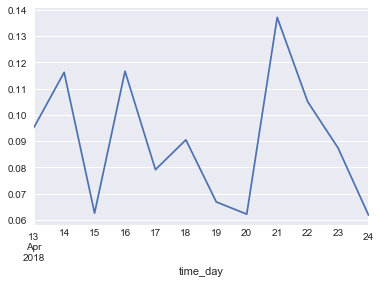

In [112]:
# Plot Rate
grouped = df.groupby('time_day')
rates = grouped[target].sum() / grouped[target].count()
rates.plot(kind='line');

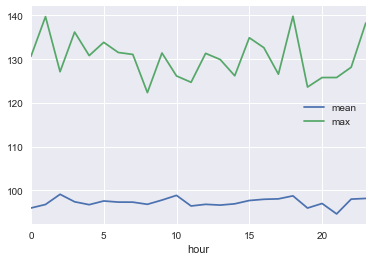

In [115]:
# Plot two aggregations over time
grouped = df.groupby('hour')
grouped['amount'].mean().plot(kind='line', label='mean');
grouped['amount'].max().plot(kind='line', label='max');
plt.legend()

### Categorical (Bar)

In [ ]:
for c in categorical:
    grouped = df.groupby(c)
    rates = grouped[target].sum() / grouped[target].count()
    print(rates)
    rates.plot(kind='bar')
    plt.show()

### Categorical (Count)

In [ ]:
for c in categorical:
    print(df[c].value_counts())
    sns.countplot(data=df, x=c, hue=target)
    plt.title(c)
    plt.show()

### Histograms (Overlap)

In [ ]:
q = df.amount.quantile(q=.3)  # First grab quartiles
for c in numerical:
    sns.distplot(df[(df[target] == 0) & (df.amount < q)][c], bins=20, label='0')
    sns.distplot(df[(df[target] == 1) & (df.amount < q)][c], bins=20, label='1')
    plt.legend()
    plt.title(c)

In [ ]:
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
df[df.label == 0].hist(column='amount', bins=20, ax=ax, label='0', alpha=.5)
df[df.label == 1].hist(column='amount', bins=20, ax=ax, label='1', alpha=.6)
plt.legend();

### Histograms (Side-by-side)

In [ ]:
g = sns.FacetGrid(df, col='label')
g.map(plt.hist, 'amount', bins=20, alpha=.8);

In [ ]:
# Facetgrid with value combos + categories
grid = sns.FacetGrid(df, col='label', row='country')
grid.map(plt.hist, 'amount', bins=20, alpha=.8)
grid.add_legend();

## Covariance

### Correlation Matrix and Heatmap

In [ ]:
# Numerical and Time only
corr = df.corr()
fig = plt.figure(figsize=(14,14))
sns.heatmap(corr, annot=True);

### Most Correlated Features

In [ ]:
corr.nlargest(n=5, columns=target)[target]
corr.nsmallest(n=5, columns=target)[target]

## Selecting Rows

### By Value

In [ ]:
# Simple
res = df[df.amount > 10]   

# Complex
df.loc[(df.label == 1) & (df.amount > 10), df.columns != 'amount'].head()

### By Index

In [ ]:
df.iloc[30:40, 1:3].head()

### Loop

In [ ]:
for idx, row in df.iterrows():
    print(idx)
    break

### Query

In [ ]:
# Simple


In [ ]:
# Complex
df['FancyName'] = np.where(
    (
        (df.Name.str.contains("Master.")) 
        | (df.Name.str.contains("Rev.")) 
        | (df.Name.str.contains("Dr."))
        | (df.Name.str.contains("Dr.")) 
        | (df.Name.str.contains("Sir."))
    ),
    True,
    False
)

## Aggregation

### Basic

In [ ]:
# Multiple statistics
df[['amount', 'daywk']].describe().T

In [ ]:
# Count occurances
df['country'].value_counts()

In [ ]:
# Mode
df[['device', 'country']].mode().T

### Custom Aggregations

In [ ]:
aggregations = {
    'class': {
        'pos': 'sum',
        'total': 'count',
        'rate': lambda x: x.sum() / x.count()
    },
    'amount': {
        'avg_amt': 'mean',
        'med_amt': 'median',
        'std_amt': 'std',
        'mode_smt': lambda x: x.value_counts().index[0]
    },
    'country': {
        'primary_country': lambda x: x.value_counts().index[0],
        'n_countries': lambda x: x.nunique()
    },
    'device': {
        'primary_device': lambda x: x.value_counts().index[0],
        'n_devices': lambda x: x.nunique()
    },
    'datetime': {
        'account_created': 'min',
        'account_age': lambda x: (datetime.datetime.utcnow() - min(x)).days
    }
}

In [ ]:
users = df.groupby('user', as_index=False).agg(aggregations)
users.columns = users.columns.droplevel()
users = users.rename(columns={'':'user'})
users.head()

### Assign columns with custom function

In [ ]:
gb = df.groupby('user').min()['datetime']
def getvalue(x):
    return gb[x]

df['created'] = df['user'].map(getvalue)
df.head()

### Assign Column with Transform

In [ ]:
df['created'] = df.groupby('user')['datetime'].transform(np.min)
df.head()

## Group by

### Single column

In [ ]:
# What's the positive rate by country?
df[['country', 'class']].groupby(
    ['country'], as_index=False).mean().sort_values(
    by='class', ascending=False)

### Multiple Columns

In [ ]:
df.groupby(['country', 'label']).median()

### Loop through groups

In [ ]:
group = df[:15].groupby('daywk')
for name, data in group:
    print(data[categorical])
    print('name', name, "primary_ctry", data.country.mode())

### Get Min/Max/Sum for Group

In [ ]:
# Multiple columns
group = df.groupby('daywk')
group.aggregate(np.min).T

In [ ]:
# Single Column
group.created.describe()

## DataFrame Restructuring

### Rename Columns

In [ ]:
df.rename(columns={'class': 'class1'}, inplace=True)
df.rename(columns={'class1': 'class'}, inplace=True)

### Drop Columns

In [ ]:
df.drop(labels=['time'], axis=1, inplace=True)
df.head()

### Merge/Join/Concat

In [ ]:
df1 = pd.DataFrame({'employee': ['Bob', 'Jake', 'Lisa', 'Sue'],
                    'group': ['Accounting', 'Engineering', 'Engineering', 'HR']})
df2 = pd.DataFrame({'employee': ['Lisa', 'Bob', 'Jake', 'Sue'],
                    'hire_date': [2004, 2008, 2012, 2014]})

In [ ]:
# Join on 'employee'
pd.merge(df1, df2, on='employee', how='inner') # default is inner

In [ ]:
# Join on index
df1.set_index('employee', inplace=True)
df2.set_index('employee', inplace=True)
df1.join(df2)

In [ ]:
# Concat
combined = pd.concat([df1, df2], axis=0)  # axis=0 will stack the dataframes (outer join)

## Null Handling

### Drop Null

In [ ]:
# Specific column
df = get_data()
df = df.dropna(how='any', subset=['country'])

In [ ]:
# Any column
df = df.dropna(how='any')

### Default Values

In [ ]:
# Constant
df['label'].fillna(value=-1, inplace=True)

# Median
df['label'].fillna(value=df['label'].median(), inplace=True)

# Multiple
df = df.fillna({
    "label": -1,
    "country": "unkown",
})

### Conditional Values

In [ ]:
df['amount'] = np.where((df['amount'] > 2000) & (df['amount'] < 10), 1000, df['amount'])

### Bfill / Ffill

In [ ]:
df['label'].fillna(method='bfill', inplace=True)
df['label'].fillna(method='ffill', inplace=True)

## Encoding

### One-Hot Encoding

In [ ]:
# Used when order doesn't matter
df = get_data()
df = pd.get_dummies(df, columns=['country'], prefix=['ctr'])
df.head()

### Ordinal Encoding

In [ ]:
# Used when order matters (ordinal)
df['country'] = df['country'].astype('category')
df['country'] = df['country'].cat.codes
df.head()

### Binning

In [ ]:
# Used to group continuous values into intervals
df = get_data()
df['amount_band'] = pd.cut(df['amount'], 5, labels=[0,1,2,3,4])
df.head()

## Normalization

### Calculate subgroup statistics

In [ ]:
# Standardization by subgroup statistics
group = df.groupby('daywk')
zscore = lambda x: (x - x.mean()) / x.std()
group.transform(zscore).head()

### Standardization

In [ ]:
# Subtract mean and divide by standard deviation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

### Normalization (Min/Max)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

### Binarization

In [ ]:
# Binarization (continuous --> 0/1)
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0.0).fit(X)
X = binarizer.transform(X)

## Feature Engineering

### Conditional

In [ ]:
df = get_data()

# np.where
df['new'] = np.where(df['amount'] > 10, 1, 0)

# df.loc
df.loc[ df['amount'] > 10, 'amount'] = 1

df.head()

### Map

In [ ]:
df['yo'] = df[target].map({
    0:'false', 
    1:'true'
})
df['name'] = df['name'].map( lambda x: x.lower() )    # Lowercase name
df.head()

### Membership

In [ ]:
popular = ['cn', 'us']
df['popular_country'] = df.country.isin(popular).astype(int)

## Train/Test Split

### Convert to Numpy

In [ ]:
def get_Xy(df):
    X = df.loc[:, df.columns != 'label'].as_matrix()
    y = df['label'].values
    return X, y

### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True # optional shuffle
)

### KFold Split

In [ ]:
from sklearn.model_selection import StratifiedKFold
fold = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)

### Time Series Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

def get_train_val_test(df, columns):
    df = get_data().sort_values(by='time')
    df = df[columns]
    trn_split = int(len(df)*.6)
    val_split = trn_split + int(len(df)*.2)
    tst_split = val_split + int(len(df)*.2)
    
    train = df[:trn_split]
    val = df[trn_split:val_split]
    test = df[val_split:]
    
    return train, val, test

### Resample

In [ ]:
from sklearn.utils import resample

def get_resampled(df, min_ratio=.1):
    positive = df.loc[df.label == 1]
    negative = df.loc[df.label == 0].sample(frac=.5)  # undersample
    n_pos = int(min_ratio*len(negative))
    positive = resample(positive, n_samples=n_pos)  # oversample
    return pd.concat([negative, positive])

## Modeling

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1.0) # C = regularization, lower = more
model.fit(X_train, y_train)
model.score(X_val, y_val)

In [ ]:
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
model.coef_ # pos = increase log odds of label

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)
model.score(X_val, y_val)

In [ ]:
# Feature importance
pd.Series(
    model.feature_importances_, 
    index=df.columns[:-1]).sort_values(
    ascending=False)[:10]

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
model.score(X_val, y_val)

### K-Means

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)
#model.fit(X_train)

## Grid Search / CV

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
# http://scikit-learn.org/stable/modules/cross_validation.html#multimetric-cross-validation
# http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection


### Grid Search

In [ ]:
# http://scikit-learn.org/stable/modules/grid_search.html
from sklearn.grid_search import GridSearchCV
params = {"n_neighbors": np.arange(1,3), "metric": ["euclidean", "cityblock"]}
grid = GridSearchCV(estimator=knn, param_grid=params)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

## Metrics

In [ ]:
# Accuracy
model.score(X_train, y_train)

In [ ]:
# Precision/Recall
from sklearn.metrics import precision_score, recall_score

In [ ]:
# F1 score
from sklearn.metrics import f1_score

In [ ]:
# F2 Score
from sklearn.metrics import fbeta_score
fbeta_score(y_test, tst_preds, pos_label=1, beta=2)

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, tst_preds))

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
scikitplot.metrics.plot_confusion_matrix(y_test, tst_preds);

In [ ]:
# ROC Curve - Recall / Specificity (FPR)
import scikitplot
scikitplot.metrics.plot_roc_curve(y_test, tst_probs);

In [ ]:
# Precision/Recall Curce
import scikitplot
skplt.metrics.plot_precision_recall_curve(y_test, tst_probs);

## Similarity

### Distance Metrics

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

# Given a matrix of numerical vectors
# Calculate the similarity of each to all other vectors
cos_sim = cosine_similarity(X, X)
euc_sim = euclidean_distances(X, X)

In [ ]:
def get_similar_users(df, simmat):
    for idx in range(len(simmat)):
        sorted_idxs = np.argsort(simmat[idx])[::-1]

        most_sim_idx = sorted_idxs[1:6]
        most_sim_val = simmat[idx][most_sim_idx]
        
        least_sim_idx = sorted_idxs[-5:]
        least_sim_val = simmat[idx][least_sim_idx]
    
get_similar_users(df, cos_sim)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors = [i for i in range(1,25,2)]
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
    cv_scores.append(scores.mean())

In [ ]:
best_score = max(cv_scores)
best_k = neighbors[cv_scores.index(best_score)]
neighbors[cv_scores.index(max(cv_scores))]
plt.plot(neighbors, cv_scores)

In [ ]:
preds = model.predict(X_train.as_matrix())

# Visualizing
normal = val.iloc[preds == 0]
pos_correct = val.loc[(preds == 1) & (y_val == 1)] 
pos_incorrect = val.loc[(preds == 1) & (y_val == 0)] 
fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(normal['V14'], normal['V11'], marker="o", color="lightBlue");
ax.scatter(pos_correct['V14'], pos_correct['V11'], marker="+", color="green");
ax.scatter(pos_incorrect['V14'], pos_incorrect['V11'], marker="+", color="red");

## Unsupervised

In [118]:
X, y = make_moons(200, noise=.05, random_state=0)

### K-Means

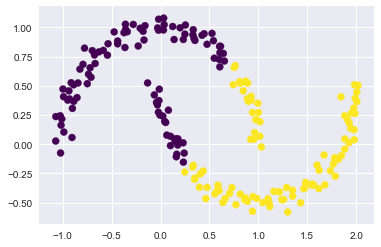

In [119]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html
# Example of a dataset without linear boundaries (points centered around mean)
from sklearn.datasets import make_moons
from sklearn.cluster import MiniBatchKMeans   # Faster

labels = MiniBatchKMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

/Users/bfortuner/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


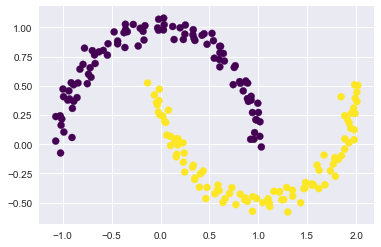

In [122]:
# Spectral Clustering (Non-Linear K-Means)
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans');
labels = model.fit_predict(X);
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Gaussian Density Estimation

In [124]:
from scipy.stats import multivariate_normal

def estimateGaussian(dataset):
    # :Dataset: is a numpy matrix of features (normal class)
    # :sigma: Covariance matrix
    # :mu: mean
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

def multivariateGaussian(dataset, mu, sigma):
    # :sigma: Covariance matrix
    # :mu: mean
    
    # Returns P(x) over multiple features 
    p = multivariate_normal(mean=mu, cov=sigma)
    probs = p.pdf(dataset)
    return probs

In [ ]:
def optimal_epsilon(probs, targets, epsilons):
    best_f2 = 0
    best_f1 = 0
    best_eps = None    
    precisions = []
    recalls = []
    f2s = []
    for eps in epsilons:
        preds = probs < eps
        f2 = fbeta_score(targets, preds, beta=2, average='binary')
        f2s.append(f2)
        precisions.append(precision_score(targets, preds))
        recalls.append(recall_score(targets, preds))
        if f2 > best_f2:
            best_f2 = f2
            #best_eps = eps
        f1 = f1_score(targets, preds, average='binary')
        if f1 > best_f1:
            best_f1 = f1
            best_eps = eps

    return best_f2, best_f1, best_eps, epsilons, f2s, precisions, recalls

In [ ]:
mu, sigma = estimateGaussian(normal.iloc[:,:-1])
probs = multivariateGaussian(X_val, mu, sigma)

In [ ]:
# Find proper thresholds
probs_df = pd.DataFrame(probs[y_val == 1])
top = probs_df.quantile(q=.95)[0]
bottom = probs_df.quantile(q=.4)[0]
bottom,top

In [ ]:
# Predict
eps = best_eps
preds = (probs < best_eps)
Recall = recall_score(y_val, preds)    
Precision = precision_score(y_val, preds)
F1score = f1_score(y_val, preds)    
print ('F1 score , Recall and Precision for Test dataset')
print ('Best F1 Score %f' %F1score)
print ('Best Recall Score %f' %Recall)
print ('Best Precision Score %f' %Precision)

In [ ]:
# Visualize Positive vs Negative

normal = val.iloc[preds == 0]
pos_correct = val.loc[(preds == 1) & (y_val == 1)] 
pos_incorrect = val.loc[(preds == 1) & (y_val == 0)] 
fig, ax = plt.subplots(figsize=(18,10))
ax.scatter(normal['V14'], normal['V11'], marker="o", color="lightBlue");
ax.scatter(pos_correct['V14'], pos_correct['V11'], marker="+", color="green");
ax.scatter(pos_incorrect['V14'], pos_incorrect['V11'], marker="+", color="red");